In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(428)

# Problem 1

In [16]:
df = pd.read_csv('ps2data.csv', index_col=0)

## Part 1
**There are not graduate students in our group**
## Part 2
Recall the MSE decomposition:
$$
\begin{align*}
MSE(\hat{f}\vert X^*) & = \mathbb{E}\left[\left(\hat{f}(X^*) - \mathbb{E}\left[\hat{f}(X^*)\right]\right)^2\bigg|X^*\right] + \left(\mathbb{E}\left[\hat{f}(X^*)\vert X^*\right] - \mathbf{f(X^*)}\right)^2  + \sigma^2\\
\end{align*}
$$
Notice that in the MSE decomposition we use the true function $f(x)$ to calculate the bias term. This is obviously not possible when $f(x)$ is unknown. 
## Part 3
### (A)
Following from the hint, we hypothesize that our data is locally linear for some small $\epsilon$. Notice that this is true for many kinds of functions, but not all functions, and thus if our data is not locally linear, a bias-variance MSE decomposition based off of this hypothesis will not be accurate.

Armed with this assumption, we can find the MSE decomposition around $x = 1.7$ of our polynomial models without knowing the true function $f(x)$. We can use the following steps:
1. We will fit a locally linear model for some $\epsilon$ neighborhood around $x = 1.7$ using the data. We then assume that this locally linear model is a good approximation for the true function $f(x)$ in this neighborhood.
2. We will calculate the bias term by comparing the locally linear model to our predicted value of $f(x)$ in this neighborhood.
3. We will find the variance of the polynomial model by sampling from the data and fitting a polynomial model to each sample. We will then calculate the variance of the predicted value of $f(x)$ in this neighborhood.


Note that for this to work, we need to choose an $\epsilon$ that is small enough to make the locally linear assumption valid, but large enough to have enough data to fit a linear model. Thus, there is a tradeoff between the power of our model and the accuracy of our locally linear assumption. To compensate, we might run this procedure for multiple values of $\epsilon$ and display all results. 

### (B)
We will carry out the above procedure on our data. 

In [17]:
# We will fit a model around x = 1.7
def local_linear_model(poi: float = 1.7, epsilon: float = 0.1) -> float:
    # Get the data points around the point of interest
    x = df['x']
    y = df['y']
    x_poi = x[(x > poi - epsilon) & (x < poi + epsilon)]
    y_poi = y[(x > poi - epsilon) & (x < poi + epsilon)]

    # Fit a local linear model and get value at poi
    model = np.polyfit(x_poi, y_poi, 1)
    y_hat = np.polyval(model, poi)
    return y_hat

def find_bias(y: float, y_hat: float) -> float:
    return (y - y_hat)**2

def find_polynomial_fit(data: pd.DataFrame, degree: int, poi: float = 1.7) -> np.ndarray:
    x = data['x']
    y = data['y']
    model = np.polyfit(x, y, degree)
    y_hat = np.polyval(model, poi)
    return y_hat

def find_polynomial_variance(data: pd.DataFrame = df, x_col: str = 'x', y_col: str = 'y', degree: int = 1, poi: float = 1.7, n_samples: int = 1000, true_y: float = 0.0) -> float:
    y_hats = []
    for sample in range(n_samples):
        sample = data.sample(frac=0.5, replace=True)
        y_hat = find_polynomial_fit(sample, degree, poi)
        y_hats.append(y_hat)
    return np.mean((y_hats - true_y)**2)

In [18]:
ys = [local_linear_model(epsilon = i) for i in [0.01, 0.05, 0.1, 0.2]]
y_hats = [find_polynomial_fit(df, i) for i in range(1, 12)]

biases_001 = [find_bias(ys[0], y_hat) for y_hat in y_hats]
biases_005 = [find_bias(ys[1], y_hat) for y_hat in y_hats]
biases_01 = [find_bias(ys[2], y_hat) for y_hat in y_hats]
biases_02 = [find_bias(ys[3], y_hat) for y_hat in y_hats]

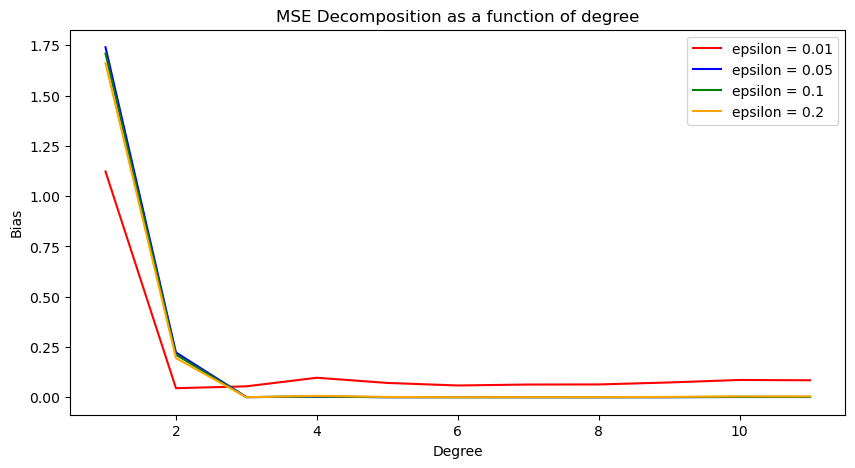

In [19]:
# Graph the results as a function of epsilon one plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(1, 12), y=biases_001, ax=ax, label='epsilon = 0.01', color='red')
sns.lineplot(x=range(1, 12), y=biases_005, ax=ax, label='epsilon = 0.05', color='blue')
sns.lineplot(x=range(1, 12), y=biases_01, ax=ax, label='epsilon = 0.1', color='green')
sns.lineplot(x=range(1, 12), y=biases_02, ax=ax, label='epsilon = 0.2', color='orange')
ax.set_title('MSE Decomposition as a function of degree')
ax.set_xlabel('Degree')
ax.set_ylabel('Bias')
plt.show()

Let's average the biases in our to make our final graph. 

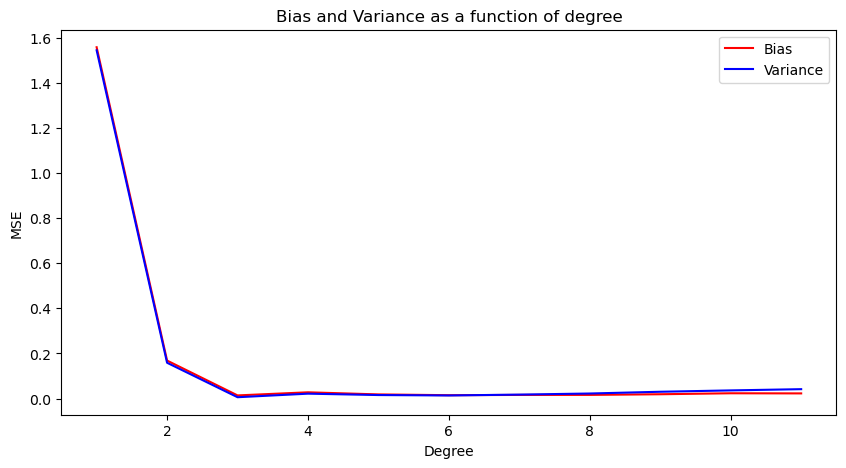

In [20]:
bias_avg = [np.mean([biases_001[i], biases_005[i], biases_01[i], biases_02[i]]) for i in range(11)]
variance = [find_polynomial_variance(degree=i, true_y=np.mean(ys)) for i in range(1, 12)]
# Graph MSE decomposition
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(1, 12), y=bias_avg, ax=ax, label='Bias', color='red')
sns.lineplot(x=range(1, 12), y=variance, ax=ax, label='Variance', color='blue')
ax.set_title('Bias and Variance as a function of degree')
ax.set_xlabel('Degree')
ax.set_ylabel('MSE')
plt.show()

### (B)

## Part 4

In [21]:
def cross_validation_fn(
    data: pd.DataFrame,
    K: int,
    func: callable,
    **kwargs
) -> float:
    """
    Perform K-fold cross validation on the given data using the given function.
    """
    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    # Split the data into K folds
    folds = np.array_split(data, K)
    # Perform cross validation
    errors = []
    for i in range(K):
        # Create the training and testing sets
        test = folds[i]
        train = pd.concat([folds[j] for j in range(K) if j != i])
        # Perform the function
        error = func(train, test, **kwargs)
        errors.append(error)
    return np.mean(errors)

In [22]:
# Use our cross validation function to find the best degree polynomial
def choose_polynomial(data: pd.DataFrame, degree: int=30) -> float:
    error = []
    for i in range(1, degree+1):
        error.append(cross_validation_fn(
            df,
            15,
            lambda train, test, degree: np.mean((np.polyval(np.polyfit(train['x'], train['y'], degree), test['x']) - test['y'])**2),
            degree=i
        ))
    return error.index(min(error)) + 1

In [23]:
%%capture 
best_degree = choose_polynomial(df)

In [24]:
print(f"The best degree polynomial is {best_degree}")

The best degree polynomial is 4


/Users/markviti/opt/anaconda3/envs/data/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/markviti/opt/anaconda3/envs/data/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


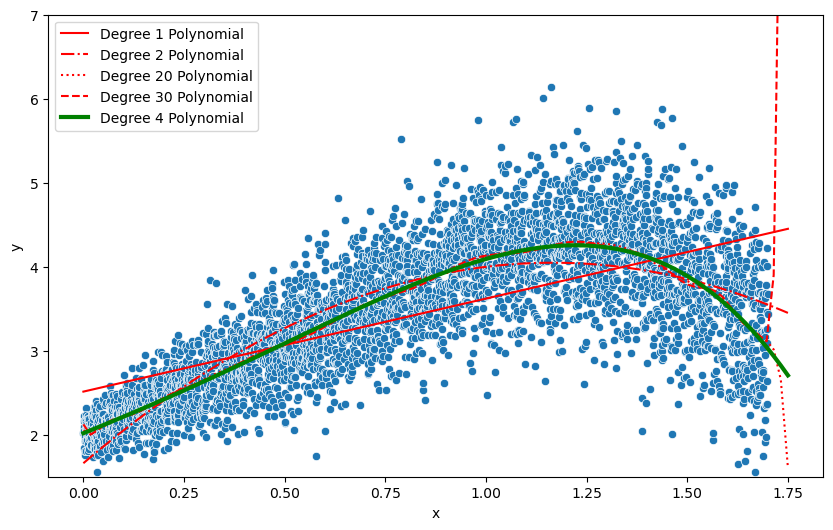

In [25]:
# Plot the best degree polynomial using sns, also including bad polynomials in red
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y')
x = np.linspace(0, 1.75, 100)
for idx, i in enumerate([1, 2, 20, 30]):
    if i != best_degree:
        y = np.polyval(np.polyfit(df['x'], df['y'], i), x)
        plt.plot(x, y, label=f"Degree {i} Polynomial", color='red', linestyle = ['-', '-.', ':', '--'][idx])
y = np.polyval(np.polyfit(df['x'], df['y'], best_degree), x)
plt.plot(x, y, label=f"Degree {best_degree} Polynomial", color='green', linewidth=3)
plt.legend()
plt.ylim(1.5, 7)
plt.show()

## Part 5
In general there are two approaches: one involves using an optimism correction and the other involves using a test sample. We will discuss each in turn:

An optimism correction leverages resampling data via a bootstrap in order to generate multiple models trained on some subset of the data. We then calculate the optimism of the model by comparing the model's performance on the bootstrap versus the original data. We then subtract the optimism from the model's performance on the original data to get an unbiased estimate of the model's performance. 

The other method involves using a testing sample by holding out some of the data to test the model's performance. This subset of the data is not used to train the model, and thus the model's performance on this subset is an unbiased estimate of the model's performance on unseen data. Notice that the splitting must be random, and this we are not introducing any bias into the testing data since we can assume that it is selected from the same distribution as any unseen data.

I strongly prefer using a train-test split since it is more intuitive and easy to implement. Packages like scipy and sklearn have built-in functions to pipeline data through a train-test split procedure, calculate relevant metrics, and even optimize hyperparameters. 

## Part 6


## Part 7

# Problem 2
**I have not seen expected optimism yet**

# Problem 3
## 1. 

In [26]:
def calc_ATE(data: pd.DataFrame) -> float:
    return data[data['treatment'] == 1]['Outcomes'].mean() - data[data['treatment'] == 0]['Outcomes'].mean()

def does_ATE_work(data: pd.DataFrame, err: float = 1e-1) -> bool:
    formula_ATE = calc_ATE(data)
    real_ATE = data[data['treatment'] != 0]['treatment'].mean() 
    print(f'Formula ATE: {formula_ATE}')
    print(f'Real ATE: {real_ATE}')
    return (abs(formula_ATE - real_ATE) < err, formula_ATE, real_ATE)

In [27]:
# Generating a random dataset such that outcomes are not well approximated by ATE
n = 1000
# Step 1: Create a dataset such that the outcome is not independent of the treatment
Y = np.random.binomial(1, 0.5, size=n)
treatment = [0 if y == 0 else 1 for y in Y]

data = pd.DataFrame({'Y': Y, 'treatment': treatment})
data['Outcomes'] = data['treatment'] + data['Y'] + np.random.normal(0, 0.1, n)

In [28]:
calc_ATE(data)
does_ATE_work(data)

Formula ATE: 1.9968642654558242
Real ATE: 1.0


(False, 1.9968642654558242, 1.0)

## 2.

In [29]:
Y_2 = np.random.binomial(1, 0.5, size=n)
treatment_2 = np.random.binomial(1, 0.5, size=n)

data_2 = pd.DataFrame({'Y': Y_2, 'treatment': treatment_2, 'Outcomes': Y_2 + treatment_2 + np.random.normal(0, 0.1, n)})
calc_ATE(data_2)
does_ATE_work(data_2)

Formula ATE: 0.9372818245229988
Real ATE: 1.0


(True, 0.9372818245229988, 1.0)

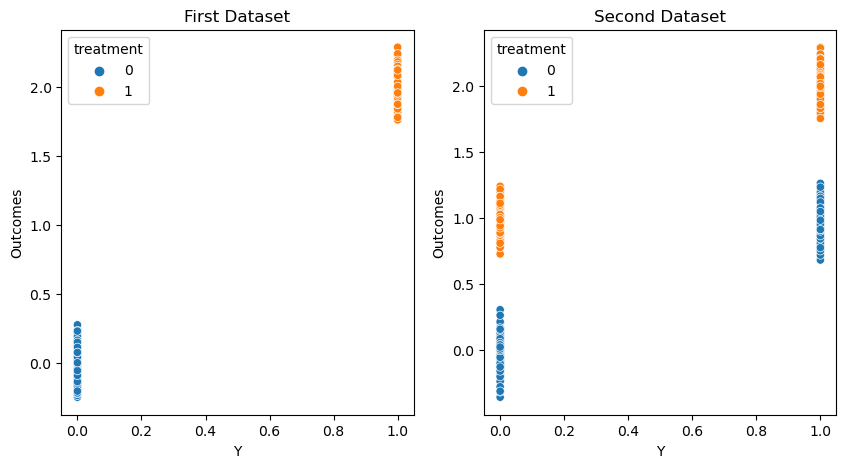

In [30]:
# Let's graph the two datasets and color them by treatment with sns
plt.figure(figsize=(10, 5))  # Optional: You can set the figure size
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='Y', y='Outcomes', hue='treatment')
plt.title('First Dataset')

plt.subplot(1, 2, 2)
sns.scatterplot(data=data_2, x='Y', y='Outcomes', hue='treatment')
plt.title('Second Dataset')
plt.show()
